In [1]:
import tensorflow as tf
print(tf.__version__)

2.1.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

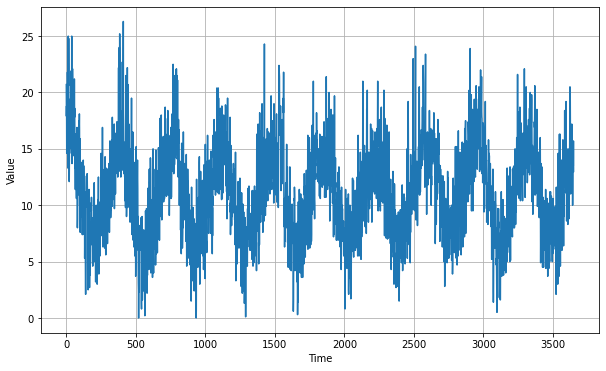

In [3]:
import csv
time_step = []
temps = []

with open('daily-min-temperatures.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    step=0
    for row in reader:
        temps.append(float(row[1]))
        time_step.append(step)
        step = step + 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [4]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [5]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [6]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [7]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Epoch 1/100
10/10 [==============================] - 9s 902ms/step - loss: 31.1551 - mae: 31.6551
Epoch 2/100
10/10 [==============================] - 4s 359ms/step - loss: 30.5849 - mae: 31.0783
Epoch 3/100
10/10 [==============================] - 3s 340ms/step - loss: 29.6259 - mae: 30.1792
Epoch 4/100
10/10 [==============================] - 3s 318ms/step - loss: 28.5432 - mae: 29.0582
Epoch 5/100
10/10 [==============================] - 3s 346ms/step - loss: 27.2554 - mae: 27.6970
Epoch 6/100
10/10 [==============================] - 4s 373ms/step - loss: 25.4769 - mae: 25.9975
Epoch 7/100
10/10 [==============================] - 4s 389ms/step - loss: 23.3469 - mae: 23.8407
Epoch 8/100
10/10 [==============================] - 4s 373ms/step - loss: 20.5459 - mae: 21.1120
Epoch 9/100
10/10 [==============================] - 3s 349ms/step - loss: 17.2022 - mae: 17.8083
Epoch 10/100
10/

10/10 [==============================] - 3s 305ms/step - loss: 11.2059 - mae: 11.7900
Epoch 85/100
10/10 [==============================] - 3s 304ms/step - loss: 12.7625 - mae: 13.2725
Epoch 86/100
10/10 [==============================] - 3s 324ms/step - loss: 14.3396 - mae: 14.8508
Epoch 87/100
10/10 [==============================] - 3s 319ms/step - loss: 16.2678 - mae: 16.5523
Epoch 88/100
10/10 [==============================] - 3s 321ms/step - loss: 18.2611 - mae: 18.8631
Epoch 89/100
10/10 [==============================] - 3s 307ms/step - loss: 20.5695 - mae: 20.8179
Epoch 90/100
10/10 [==============================] - 3s 305ms/step - loss: 23.1368 - mae: 23.7310
Epoch 91/100
10/10 [==============================] - 3s 302ms/step - loss: 26.0270 - mae: 26.2309
Epoch 92/100
10/10 [==============================] - 3s 305ms/step - loss: 29.2749 - mae: 29.8358
Epoch 93/100
10/10 [==============================] - 3s 301ms/step - loss: 32.8635 - mae: 33.0553
Epoch 94/100
10/10 [===

(1e-08, 0.0001, 0.0, 60.0)

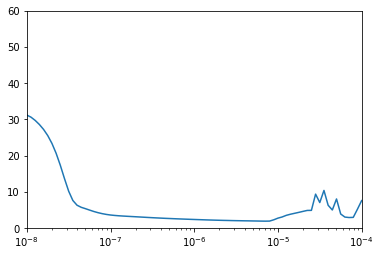

In [8]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [9]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)

Epoch 1/150
25/25 [==============================] - 7s 282ms/step - loss: 9.9673 - mae: 10.5789
Epoch 2/150
25/25 [==============================] - 3s 121ms/step - loss: 2.5738 - mae: 3.0493
Epoch 3/150
25/25 [==============================] - 3s 125ms/step - loss: 1.9326 - mae: 2.3879
Epoch 4/150
25/25 [==============================] - 3s 125ms/step - loss: 1.8648 - mae: 2.3160
Epoch 5/150
25/25 [==============================] - 3s 132ms/step - loss: 1.8189 - mae: 2.2715
Epoch 6/150
25/25 [==============================] - 3s 129ms/step - loss: 1.7909 - mae: 2.2419
Epoch 7/150
25/25 [==============================] - 3s 128ms/step - loss: 1.7627 - mae: 2.2129
Epoch 8/150
25/25 [==============================] - 3s 127ms/step - loss: 1.7430 - mae: 2.1939
Epoch 9/150
25/25 [==============================] - 3s 125ms/step - loss: 1.7179 - mae: 2.1688
Epoch 10/150
25/25 [==============================] - 3s 126ms/step - loss: 1.6983 - mae: 2.1483
Epoch 11/150
25/25 [==================

25/25 [==============================] - 3s 100ms/step - loss: 1.5032 - mae: 1.9453
Epoch 87/150
25/25 [==============================] - 2s 93ms/step - loss: 1.5026 - mae: 1.9444
Epoch 88/150
25/25 [==============================] - 3s 104ms/step - loss: 1.5039 - mae: 1.9453
Epoch 89/150
25/25 [==============================] - 2s 87ms/step - loss: 1.5001 - mae: 1.9432
Epoch 90/150
25/25 [==============================] - 2s 91ms/step - loss: 1.5020 - mae: 1.9427
Epoch 91/150
25/25 [==============================] - 2s 89ms/step - loss: 1.5016 - mae: 1.9442
Epoch 92/150
25/25 [==============================] - 2s 87ms/step - loss: 1.5010 - mae: 1.9433
Epoch 93/150
25/25 [==============================] - 2s 83ms/step - loss: 1.4981 - mae: 1.9404
Epoch 94/150
25/25 [==============================] - 2s 90ms/step - loss: 1.4973 - mae: 1.9392
Epoch 95/150
25/25 [==============================] - 2s 87ms/step - loss: 1.4952 - mae: 1.9376
Epoch 96/150
25/25 [==============================]

In [10]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

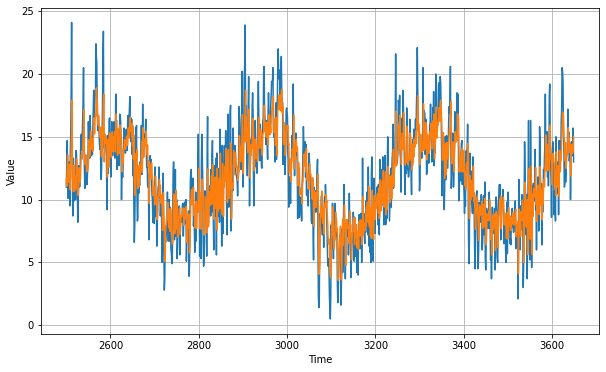

In [11]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [12]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

1.781388

In [13]:
print(rnn_forecast)

[11.668881 11.051163 12.271483 ... 13.672188 13.805072 15.02254 ]
